In [8]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
from torch import nn
from torch import optim
from torch.autograd import Variable
from torch.autograd import grad

from scipy.stats import norm
import math
import numpy as np
import os
import time
from numpy import save
from numpy import load

from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# from https://people.sc.fsu.edu/~jburkardt/py_src/burgers_solution/burgers_solution.html
import burgers
from burgers import burgers_viscous_time_exact1

### Burgers' Equation

$$
\frac{\partial u(x,t)}{\partial t} ~+~ u(x,t) \frac{\partial u(x,t)}{\partial x} ~=~ \nu \frac{\partial^2 u(x,t)}{\partial x^2}
$$

$$u(x,t)\vert_{t=0}=-\sin{(\pi x)}$$

$$u(x,t)\vert_{x=-1}=0$$

$$u(x,t)\vert_{x=1}=0$$

In [9]:
def nth_derivative(f, wrt, n):
    for i in range(n):
        grads = grad(f, wrt, create_graph=True, allow_unused=True)[0]
        f = grads
        if grads is None:
            print('bad grad')
            return torch.tensor(0.)
    return grads

In [10]:
def flat(x):
    m = x.shape[0]
    return [x[i] for i in range(m)]

In [11]:
class MLP_2D(nn.Module):
    
    def __init__(self, equation, init_cond):
        super().__init__()
        self.equation = equation
        
        # initial & boundary conditions: IBVP1D (Dirichlet-Dirichlet)
        self.t_min, self.t_min_val, self.x_min, self.x_min_val, self.x_max, self.x_max_val = init_cond
        
        # add layers
        self.hidden1 = nn.Linear(2,80)
        self.hidden2 = nn.Linear(80,80)
        self.hidden3 = nn.Linear(80,80)
        self.hidden4 = nn.Linear(80,40)
        self.out = nn.Linear(40,1)
        self.tn = nn.Tanh()
        self.layers = nn.ModuleList([self.hidden1, self.hidden2, self.hidden3, self.hidden4, self.out])
        
    def forward(self, x, t):
        # do forward pass
        u = torch.cat((x, t), 1)
        u = self.hidden1(u)
        for l in self.layers[1:]:
            u = l(self.tn(u))
        
        # re-parametrize (for IBVP1D (Dirichlet-Dirichlet))
        x_tilde = (x - self.x_min)/(self.x_max - self.x_min)
        t_tilde = t - self.t_min
        t0 = self.t_min*torch.ones_like(t, requires_grad=True)
        Axt = self.t_min_val(x) + \
              x_tilde*(self.x_max_val(t) - self.x_max_val(t0)) + \
              (1 - x_tilde)*(self.x_min_val(t) - self.x_min_val(t0))
        
        # enforce initial conditions (for IBVP1D (Dirichlet-Dirichlet))
        u = Axt + x_tilde*(1 - x_tilde)*(1 - torch.exp(-t_tilde))*u
        return u
    
    def simple_loss(self, x, t):
        u_tilde = self(x, t)
        u_t_tilde = nth_derivative(flat(u_tilde), wrt=t, n=1)
        u_x_tilde = nth_derivative(flat(u_tilde), wrt=x, n=1)
        u_xx_tilde = nth_derivative(flat(u_x_tilde), wrt=x, n=1)
        res_tilde = self.equation(u_tilde, u_x_tilde, u_t_tilde, u_xx_tilde)
        loss = (res_tilde**2).mean()
        return loss

In [12]:
# specify training domain
x_min = -1.0
x_max = 1.0
t_min = 0.0
t_max = 1.0

# specify number of training points
nx = 20
nt = 20

# generate training points 
x = torch.linspace(x_min, x_max, nx, requires_grad=True)
t = torch.linspace(t_min, t_max, nt, requires_grad=True)
grid_x, grid_t = torch.meshgrid(x, t)
x_train, t_train = grid_x.flatten().unsqueeze(0).t(), grid_t.flatten().unsqueeze(0).t()

In [13]:
# initial conditions
init_cond = (t_min, lambda x: -torch.sin(np.pi*x), x_min, lambda t: torch.zeros_like(t), x_max, lambda t: torch.zeros_like(t))

# differential equation (Burgers' equation)
equation = lambda u, u_x, u_t, u_xx: u_t + u*u_x - torch.tensor(0.01/np.pi)*u_xx

# instantiate network
model_2D = MLP_2D(equation, init_cond)

In [7]:
# train the model

# choose optimizer
optimizer = optim.SGD(model_2D.parameters(), lr=0.01)

# train
epochs = 20000
loss_vals = []
for epoch in range(epochs):
    
    loss = model_2D.simple_loss(x_train, t_train)
    
    optimizer.zero_grad()
    loss.backward()
    loss_vals.append(loss.item())
    optimizer.step()
    
    if epoch % 1000 == 999:
        with torch.no_grad():
            print(f'Epoch: {epoch + 1} Loss: {loss.item():.3f}')

Epoch: 1000 Loss: 0.482
Epoch: 2000 Loss: 0.451
Epoch: 3000 Loss: 0.437
Epoch: 4000 Loss: 0.425
Epoch: 5000 Loss: 0.406
Epoch: 6000 Loss: 0.385
Epoch: 7000 Loss: 0.370
Epoch: 8000 Loss: 0.356
Epoch: 9000 Loss: 0.343
Epoch: 10000 Loss: 0.330
Epoch: 11000 Loss: 0.313
Epoch: 12000 Loss: 0.292
Epoch: 13000 Loss: 0.264
Epoch: 14000 Loss: 0.162
Epoch: 15000 Loss: 0.119
Epoch: 16000 Loss: 0.088
Epoch: 17000 Loss: 0.069
Epoch: 18000 Loss: 0.061
Epoch: 19000 Loss: 0.052
Epoch: 20000 Loss: 0.047


In [14]:
# save/load weights

#torch.save(model_2D.state_dict(), 'weights_burgers_my.t7')
model_2D.load_state_dict(torch.load('weights_burgers_my.t7'))

<All keys matched successfully>

In [15]:
# prepare for plotting

# specify domain
x_min_p = -1.0
x_max_p = 1.0
t_min_p = 0.0
t_max_p = 2.0

# specify number of points
nx_p = 101
nt_p = 101

# define x-axis and t-axis
x_axis = np.linspace(x_min_p, x_max_p, nx_p)
t_axis = np.linspace(t_min_p, t_max_p, nt_p)
x_grid, t_grid = np.meshgrid(t_axis, x_axis)

# get the exact solution
u_true = burgers_viscous_time_exact1(0.01/np.pi, nx_p, x_axis, nt_p, t_axis)

# x-axis and t-axis as torch tensors
x_axis_tch = torch.from_numpy(x_axis).float().reshape(nx_p, 1, 1)
t_axis_tch = torch.from_numpy(t_axis).float().reshape(nt_p, 1, 1)

# get the solution matrix
u_nn = np.zeros((nx_p, nt_p))
for i in range(0, nx_p):
    for j in range(0, nt_p):
        u_nn[i][j] = model_2D(x_axis_tch[i], t_axis_tch[j]).detach().numpy()

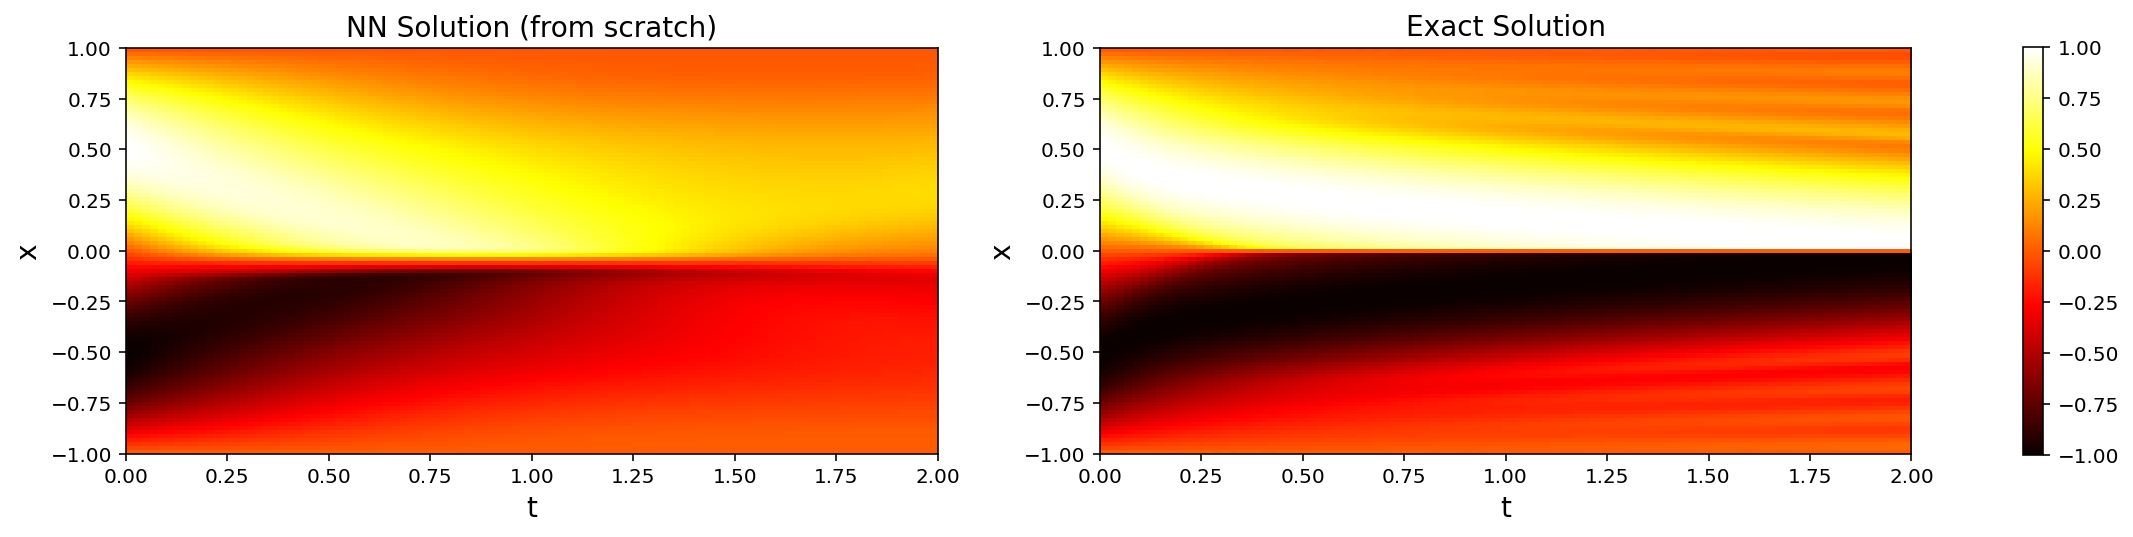

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
ax[0].set_title('NN Solution (from scratch)', fontsize=14)
ax[0].set_xlabel('t', fontsize=14), ax[0].set_ylabel('x', fontsize=14)
im1 = ax[0].imshow(u_nn, cmap='hot', interpolation='nearest', extent=[t_min_p, t_max_p, x_min_p, x_max_p], vmin=-1, vmax=1, aspect=0.5);
ax[1].set_title('Exact Solution', fontsize=14)
ax[1].set_xlabel('t', fontsize=14), ax[1].set_ylabel('x', fontsize=14)
im2 = ax[1].imshow(u_true, cmap='hot', interpolation='nearest', extent=[t_min_p, t_max_p, x_min_p, x_max_p], vmin=-1, vmax=1, aspect=0.5);
fig.colorbar(im1, ax=ax.ravel().tolist(), shrink=0.75);

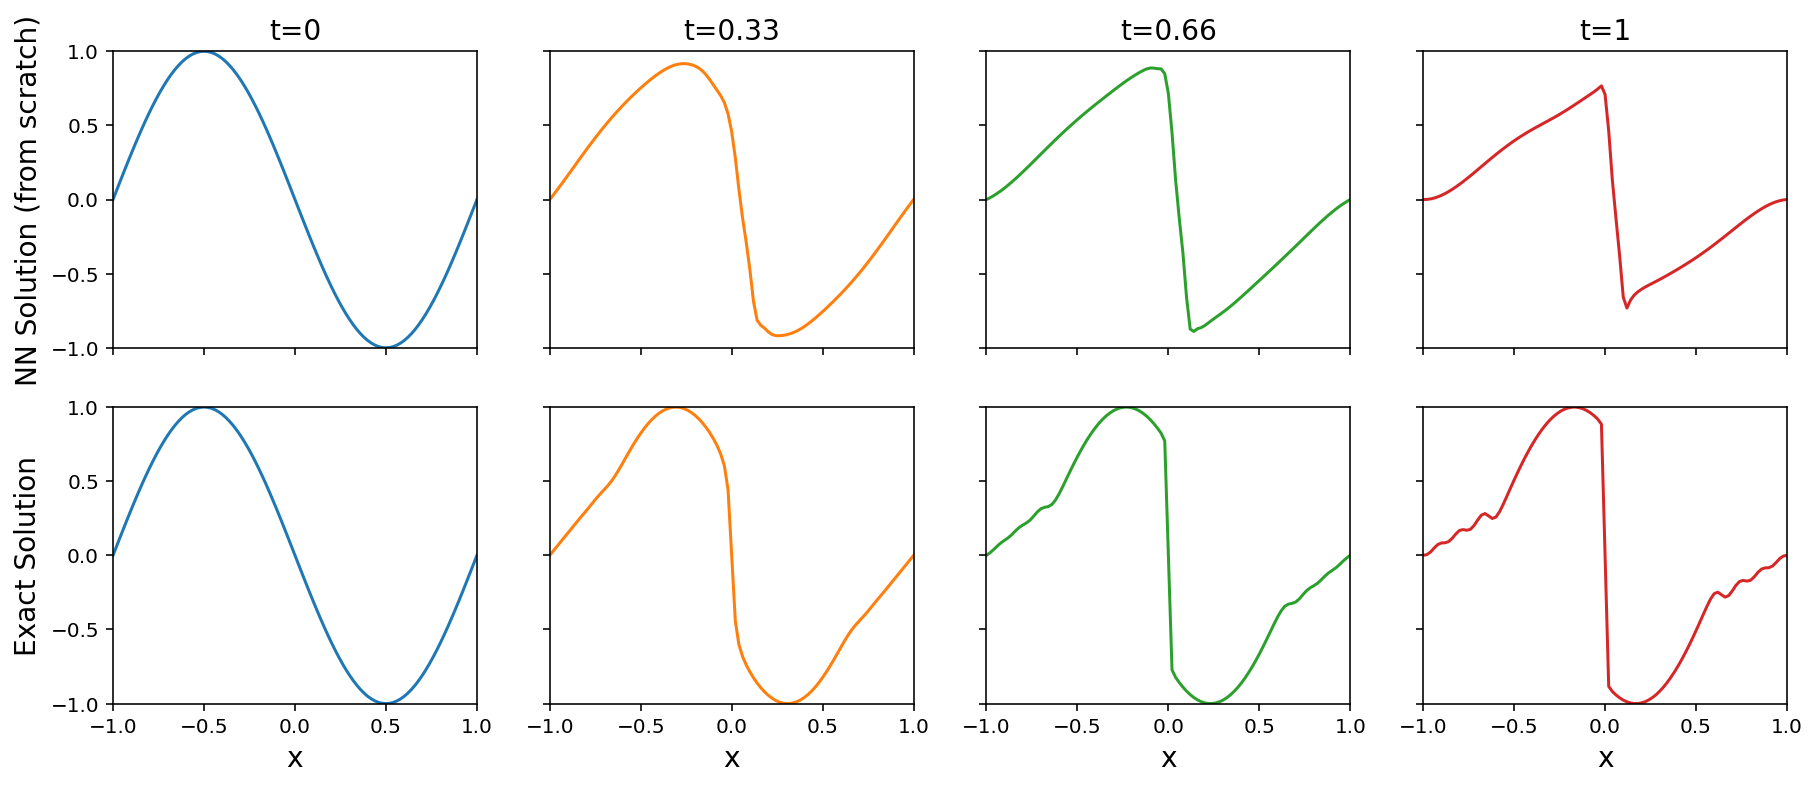

In [17]:
fig, axs = plt.subplots(2, 4, figsize=(15,6))
axs[0, 0].plot(x_axis, u_nn[:,0], 'tab:blue'), axs[0, 0].set_xlim([x_min_p,x_max_p]), axs[0, 0].set_ylim([-1,1]), axs[0, 0].set_title('t=0', fontsize=14)
axs[0, 1].plot(x_axis, u_nn[:,17], 'tab:orange'), axs[0, 1].set_xlim([x_min_p,x_max_p]), axs[0, 1].set_ylim([-1,1]), axs[0, 1].set_title('t=0.33', fontsize=14)
axs[0, 2].plot(x_axis, u_nn[:,33], 'tab:green'), axs[0, 2].set_xlim([x_min_p,x_max_p]), axs[0, 2].set_ylim([-1,1]), axs[0, 2].set_title('t=0.66', fontsize=14)
axs[0, 3].plot(x_axis, u_nn[:,50], 'tab:red'), axs[0, 3].set_xlim([x_min_p,x_max_p]), axs[0, 3].set_ylim([-1,1]), axs[0, 3].set_title('t=1', fontsize=14)
axs[1, 0].plot(x_axis, u_true[:,0], 'tab:blue'), axs[1, 0].set_xlim([x_min_p,x_max_p]), axs[1, 0].set_ylim([-1,1])
axs[1, 1].plot(x_axis, u_true[:,17], 'tab:orange'), axs[1, 1].set_xlim([x_min_p,x_max_p]), axs[1, 1].set_ylim([-1,1])
axs[1, 2].plot(x_axis, u_true[:,33], 'tab:green'), axs[1, 2].set_xlim([x_min_p,x_max_p]), axs[1, 2].set_ylim([-1,1])
axs[1, 3].plot(x_axis, u_true[:,50], 'tab:red'), axs[1, 3].set_xlim([x_min_p,x_max_p]), axs[1, 3].set_ylim([-1,1])
for ax in axs.flat:
    ax.set_xlabel('x', fontsize=14)
for ax in axs[0, :]:
    ax.set_ylabel('NN Solution (from scratch)', fontsize=14)
for ax in axs[1, :]:
    ax.set_ylabel('Exact Solution', fontsize=14)
for ax in axs.flat:
    ax.label_outer()
plt.show()

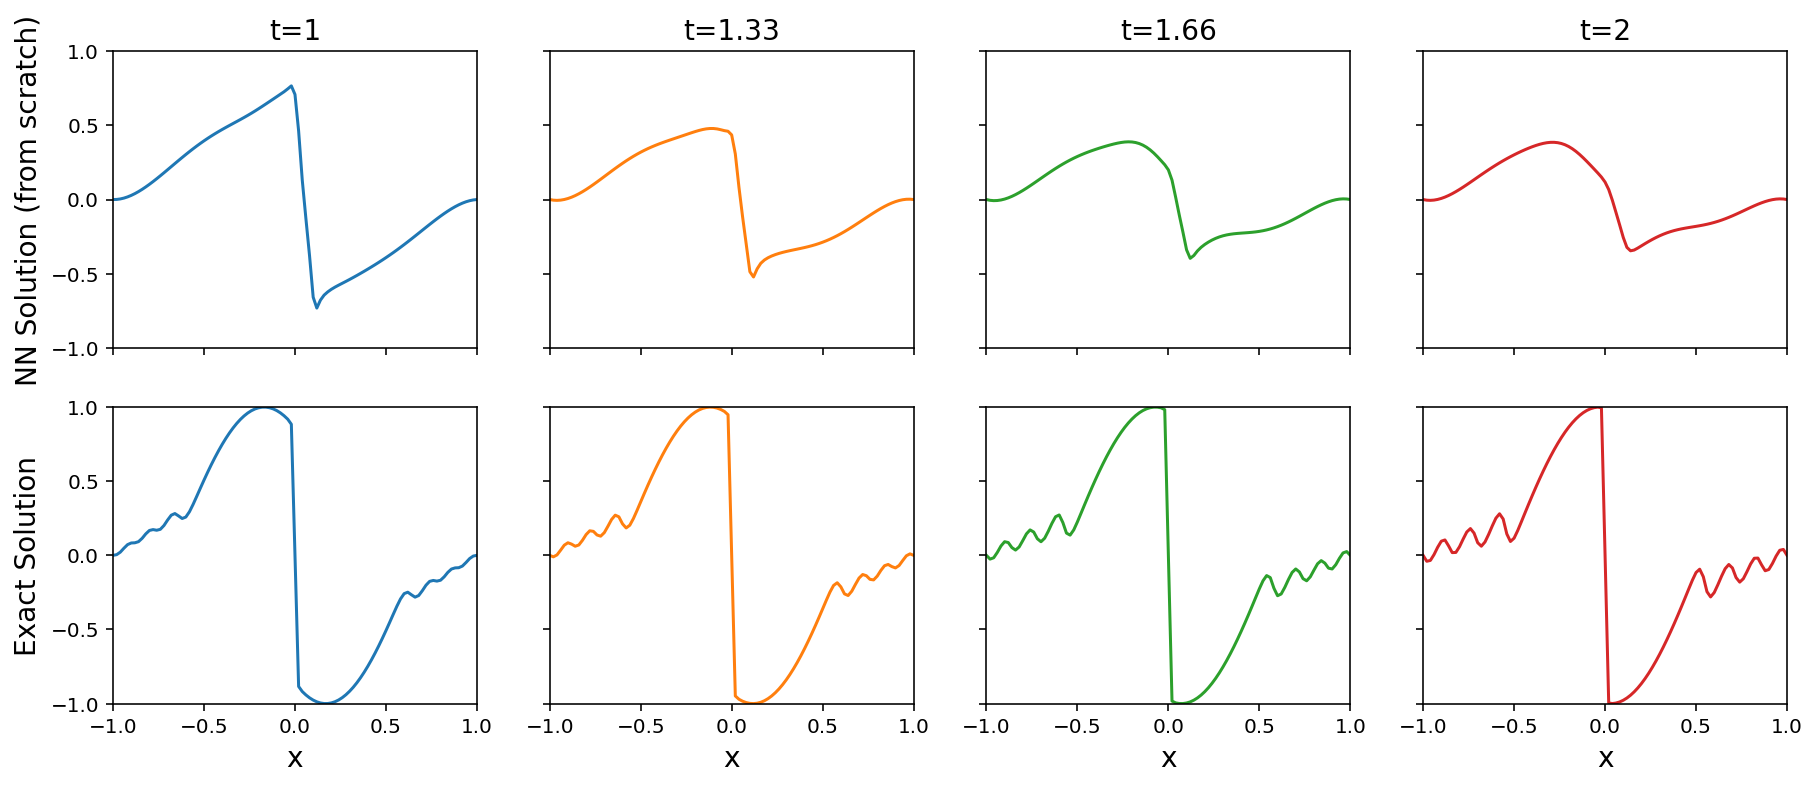

In [18]:
fig, axs = plt.subplots(2, 4, figsize=(15,6))
axs[0, 0].plot(x_axis, u_nn[:,50], 'tab:blue'), axs[0, 0].set_xlim([x_min_p,x_max_p]), axs[0, 0].set_ylim([-1,1]), axs[0, 0].set_title('t=1', fontsize=14)
axs[0, 1].plot(x_axis, u_nn[:,67], 'tab:orange'), axs[0, 1].set_xlim([x_min_p,x_max_p]), axs[0, 1].set_ylim([-1,1]), axs[0, 1].set_title('t=1.33', fontsize=14)
axs[0, 2].plot(x_axis, u_nn[:,84], 'tab:green'), axs[0, 2].set_xlim([x_min_p,x_max_p]), axs[0, 2].set_ylim([-1,1]), axs[0, 2].set_title('t=1.66', fontsize=14)
axs[0, 3].plot(x_axis, u_nn[:,nt_p-1], 'tab:red'), axs[0, 3].set_xlim([x_min_p,x_max_p]), axs[0, 3].set_ylim([-1,1]), axs[0, 3].set_title('t=2', fontsize=14)
axs[1, 0].plot(x_axis, u_true[:,50], 'tab:blue'), axs[1, 0].set_xlim([x_min_p,x_max_p]), axs[1, 0].set_ylim([-1,1])
axs[1, 1].plot(x_axis, u_true[:,67], 'tab:orange'), axs[1, 1].set_xlim([x_min_p,x_max_p]), axs[1, 1].set_ylim([-1,1])
axs[1, 2].plot(x_axis, u_true[:,84], 'tab:green'), axs[1, 2].set_xlim([x_min_p,x_max_p]), axs[1, 2].set_ylim([-1,1])
axs[1, 3].plot(x_axis, u_true[:,nt_p-1], 'tab:red'), axs[1, 3].set_xlim([x_min_p,x_max_p]), axs[1, 3].set_ylim([-1,1])
for ax in axs.flat:
    ax.set_xlabel('x', fontsize=14)
for ax in axs[0, :]:
    ax.set_ylabel('NN Solution (from scratch)', fontsize=14)
for ax in axs[1, :]:
    ax.set_ylabel('Exact Solution', fontsize=14)
for ax in axs.flat:
    ax.label_outer()
plt.show()